In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.generators.degree_seq import random_degree_sequence_graph
from networkx.algorithms.graphical import is_graphical
from networkx.utils.random_sequence import powerlaw_sequence
import matplotlib.pyplot as plt
plt.style.use('../figures/norm.mplstyle')
from ldpc.code_util import *
from ldpc.mod2 import *
from bposd.hgp import hgp
from bposd.css import css_code, compute_code_distance
import sys, os
from timeit import default_timer as timer
import cairo
import cmath
import multiprocessing as mp
from functools import partial
from tqdm import tqdm


def read_pc(filepath):
    """
    Read parity check matrix from file.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    pc = []
    for line in lines:
        row = [int(x) for x in line.split()]
        pc.append(row)
    return np.array(pc, dtype=np.uint8)

def get_classical_code_distance_time_limit(h):
    if rank(h) == h.shape[1]:
        print('Code is full rank, no codewords')
        return np.inf
    else:
        start = timer()
        ker = nullspace(h)
        end = timer()
        def find_min_weight_while_build(matrix):
            span = []
            min_hamming_weight = np.inf
            for ir, row in enumerate(matrix):
                row_hamming_weight = np.sum(row)
                if row_hamming_weight < min_hamming_weight:
                    min_hamming_weight = row_hamming_weight
                temp = [row]
                for element in span:
                    newvec = (row + element) % 2
                    temp.append(newvec)
                    newvec_hamming_weight = np.sum(newvec)
                    if newvec_hamming_weight < min_hamming_weight:
                        min_hamming_weight = newvec_hamming_weight
                    end = timer()
                    if end - start > 5:
                        return min_hamming_weight
                span = list(np.unique(temp + span, axis=0))
            assert len(span) == 2**len(matrix) - 1
            return min_hamming_weight
        min_hamming_weight = find_min_weight_while_build(ker)
        end = timer()
        return min_hamming_weight
    
def bin_points(point, linear_size, nbars=5):
    x, y = point
    x = x / linear_size
    y = y / linear_size
    if x > 0.5:
        x = 1. - x
    if y > 0.5:
        y = 1. - y
    lookat = min(x, y)
    k = np.floor(lookat/(0.5/(nbars)))
    return k

#### k,d

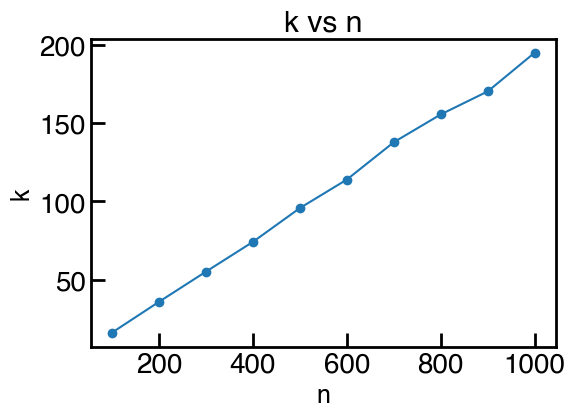

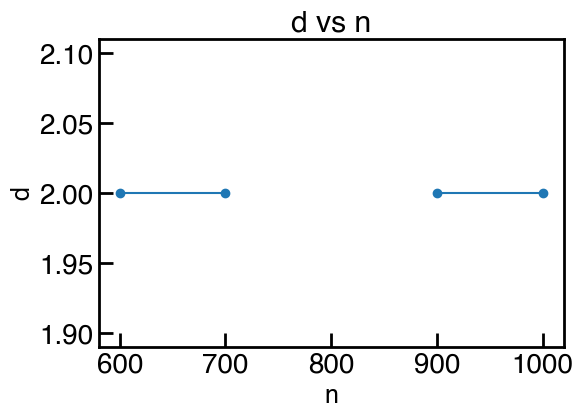

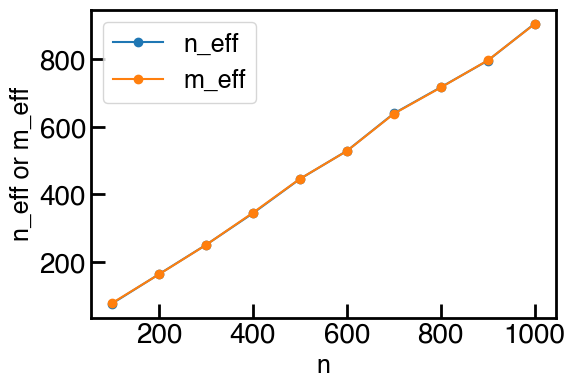

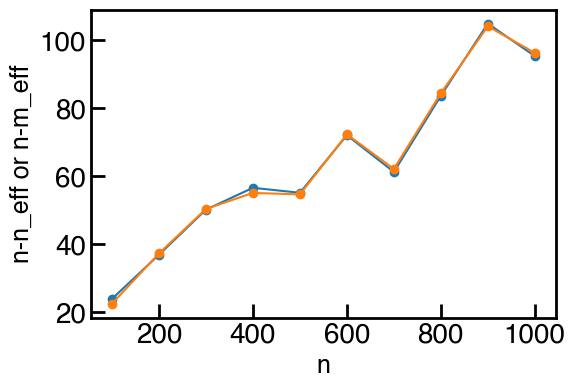

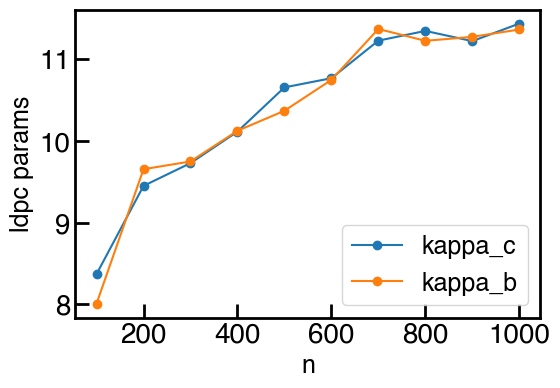

In [32]:
proportionality = 0.1
const = 8
ns = np.arange(100, 1050, 100)
ms = np.arange(100, 1050, 100)
seeds = range(101)
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'

ns_eff = []
ms_eff = []
ks = []
ds = []
kappa_cs = []
kappa_bs = []
for n, m in zip(ns, ms):
    ms_eff.append([])
    ns_eff.append([])
    ks.append([])
    ds.append([])
    kappa_cs.append([])
    kappa_bs.append([])
    for seed in seeds:
        readname = f'removed_data_rgg_benchmark_n={n}_m={m}_proportionality={proportionality}_const={const}_seed={seed}.npz'
        filepath = os.path.join(readdir, readname)
        if os.path.exists(filepath):
            data = np.load(filepath)
            ms_eff[-1].append(data['m_eff'])
            ns_eff[-1].append(data['n_eff'])
            ks[-1].append(data['k'])
            ds[-1].append(data['d'])
            kappa_cs[-1].append(data['ldpc_params'][0])
            kappa_bs[-1].append(data['ldpc_params'][1])

ks_avg = np.array([np.average(k) for k in ks])
ds_avg = np.array([np.average(d) for d in ds])
ns_eff_avg = np.array([np.average(n) for n in ns_eff])
ms_eff_avg = np.array([np.average(m) for m in ms_eff])
kappa_cs_avg = np.array([np.average(kappa_c) for kappa_c in kappa_cs])
kappa_bs_avg = np.array([np.average(kappa_b) for kappa_b in kappa_bs])

fig, ax = plt.subplots()
ax.plot(ns, ks_avg, 'o-')
ax.set_xlabel('n')
ax.set_ylabel('k')
ax.set_title('k vs n')
plt.show()

fig, ax = plt.subplots()
ax.plot(ns, ds_avg, 'o-')
ax.set_xlabel('n')
ax.set_ylabel('d')
ax.set_title('d vs n')
plt.show()

fig, ax = plt.subplots()
ax.plot(ns, ns_eff_avg, 'o-', label='n_eff')
ax.plot(ns, ms_eff_avg, 'o-', label='m_eff')
ax.set_xlabel('n')
ax.set_ylabel('n_eff or m_eff')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ns, ns-ns_eff_avg, 'o-', label='n-n_eff')
ax.plot(ns, ns-ms_eff_avg, 'o-', label='n-m_eff')
ax.set_xlabel('n')
ax.set_ylabel('n-n_eff or n-m_eff')
plt.show()

fig, ax = plt.subplots()
ax.plot(ns, kappa_cs_avg, 'o-', label='kappa_c')
ax.plot(ns, kappa_bs_avg, 'o-', label='kappa_b')
ax.set_xlabel('n')
ax.set_ylabel('ldpc params')
ax.legend()
plt.show()

#### removed nodes + degree stats

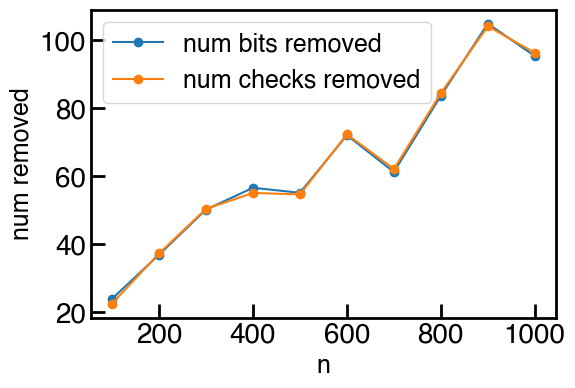

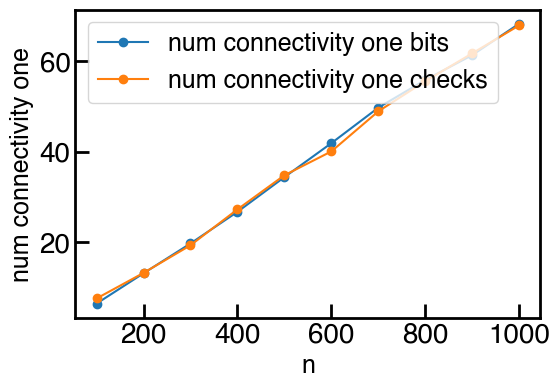

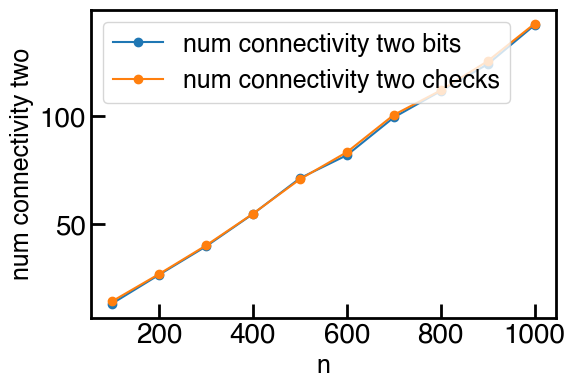

In [33]:
proportionality = 0.1
const = 8
ns = np.arange(100, 1050, 100)
ms = np.arange(100, 1050, 100)
seeds = range(101)
readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/ldpc_code'

num_bits_removed = []
num_checks_removed = []
num_connectivity_one_bits = []
num_connectivity_one_checks = []
num_connectivity_two_bits = []
num_connectivity_two_checks = []
for n, m in zip(ns, ms):
    num_bits_removed.append([])
    num_checks_removed.append([])
    num_connectivity_one_bits.append([])
    num_connectivity_one_checks.append([])
    num_connectivity_two_bits.append([])
    num_connectivity_two_checks.append([])
    for seed in seeds:
        readname = f'removed_data_rgg_benchmark_n={n}_m={m}_proportionality={proportionality}_const={const}_seed={seed}.npz'
        filepath = os.path.join(readdir, readname)
        if os.path.exists(filepath):
            data = np.load(filepath)
            num_bits_removed[-1].append(len(data['removed_bits']))
            num_checks_removed[-1].append(len(data['removed_checks']))
            num_connectivity_one_bits[-1].append(len(data['connectivity_one_bits']))
            num_connectivity_one_checks[-1].append(len(data['connectivity_one_checks']))
            num_connectivity_two_bits[-1].append(len(data['connectivity_two_bits']))
            num_connectivity_two_checks[-1].append(len(data['connectivity_two_checks']))
            
num_bits_removed_avg = np.array([np.average(num_bits) for num_bits in num_bits_removed])
num_checks_removed_avg = np.array([np.average(num_checks) for num_checks in num_checks_removed])
num_connectivity_one_bits_avg = np.array([np.average(num_bits) for num_bits in num_connectivity_one_bits])
num_connectivity_one_checks_avg = np.array([np.average(num_checks) for num_checks in num_connectivity_one_checks])
num_connectivity_two_bits_avg = np.array([np.average(num_bits) for num_bits in num_connectivity_two_bits])
num_connectivity_two_checks_avg = np.array([np.average(num_checks) for num_checks in num_connectivity_two_checks])

fig, ax = plt.subplots()
ax.plot(ns, num_bits_removed_avg, 'o-', label='num bits removed')
ax.plot(ns, num_checks_removed_avg, 'o-', label='num checks removed')
ax.set_xlabel('n')
ax.set_ylabel('num removed')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ns, num_connectivity_one_bits_avg, 'o-', label='num connectivity one bits')
ax.plot(ns, num_connectivity_one_checks_avg, 'o-', label='num connectivity one checks')
ax.set_xlabel('n')
ax.set_ylabel('num connectivity one')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ns, num_connectivity_two_bits_avg, 'o-', label='num connectivity two bits')
ax.plot(ns, num_connectivity_two_checks_avg, 'o-', label='num connectivity two checks')
ax.set_xlabel('n')
ax.set_ylabel('num connectivity two')
ax.legend()
plt.show()